In [1]:
import pandas as pd
import numpy as np
import linopy
import pypsa

In [21]:
import tqdm

In [2]:
from pypsa.descriptors import get_switchable_as_dense as as_dense

In [3]:
def replace_su(network, su_to_replace):

    su = network.storage_units.loc[su_to_replace]

    bus_name = "{} {}".format(su["bus"], su["carrier"])
    link_1_name = "{} converter {} to AC".format(su_to_replace, su["carrier"])
    link_2_name = "{} converter AC to {}".format(su_to_replace, su["carrier"])
    store_name = "{} store {}".format(su_to_replace, su["carrier"])
    gen_name = "{} inflow".format(su_to_replace)

    if bus_name not in network.buses.index:
        network.add("Bus", bus_name, carrier=su["carrier"])

    # dispatch link
    network.add(
        "Link",
        link_1_name,
        bus0=bus_name,
        bus1=su["bus"],
        capital_cost=su["capital_cost"] * su["efficiency_dispatch"],
        p_nom=su["p_nom"] / su["efficiency_dispatch"],
        p_nom_extendable=su["p_nom_extendable"],
        p_nom_max=su["p_nom_max"] / su["efficiency_dispatch"],
        p_nom_min=su["p_nom_min"] / su["efficiency_dispatch"],
        p_max_pu=su["p_max_pu"],
        marginal_cost=su["marginal_cost"] * su["efficiency_dispatch"],
        efficiency=su["efficiency_dispatch"],
        carrier = su["carrier"],
        type="discharging",
    )

    # store link
    network.add(
        "Link",
        link_2_name,
        bus1=bus_name,
        bus0=su["bus"],
        p_nom=su["p_nom"],
        p_nom_extendable=su["p_nom_extendable"],
        p_nom_max=su["p_nom_max"],
        p_nom_min=su["p_nom_min"],
        p_max_pu=-su["p_min_pu"],
        efficiency=su["efficiency_store"],
        carrier = su["carrier"],
        type="charging"
    )

    if (
        su_to_replace in network.storage_units_t.state_of_charge_set.columns
        and (
            ~pd.isnull(network.storage_units_t.state_of_charge_set[su_to_replace])
        ).any()
    ):
        e_max_pu = pd.Series(data=1.0, index=network.snapshots)
        e_min_pu = pd.Series(data=0.0, index=network.snapshots)
        non_null = ~pd.isnull(
            network.storage_units_t.state_of_charge_set[su_to_replace]
        )
        e_max_pu[non_null] = network.storage_units_t.state_of_charge_set[su_to_replace][
            non_null
        ]
        e_min_pu[non_null] = network.storage_units_t.state_of_charge_set[su_to_replace][
            non_null
        ]
    else:
        e_max_pu = 1.0
        e_min_pu = 0.0

    network.add(
        "Store",
        store_name,
        bus=bus_name,
        e_nom=su["p_nom"] * su["max_hours"],
        e_nom_min=su["p_nom_min"] / su["efficiency_dispatch"] * su["max_hours"],
        e_nom_max=su["p_nom_max"] / su["efficiency_dispatch"] * su["max_hours"],
        e_nom_extendable=su["p_nom_extendable"],
        e_max_pu=e_max_pu,
        e_min_pu=e_min_pu,
        standing_loss=su["standing_loss"],
        e_cyclic=su["cyclic_state_of_charge"],
        e_initial=su["state_of_charge_initial"],
        carrier = su["carrier"]
    )


    # inflow from a variable generator, which can be curtailed (i.e. spilled)
    inflow_max = as_dense(network, "StorageUnit", "inflow").max()[su_to_replace]
    
    if inflow_max == 0.0:
        inflow_pu = 0.0
    else:
        inflow_pu = network.storage_units_t.inflow[su_to_replace] / inflow_max

    if inflow_max >0:
        network.add(
            "Generator",
            gen_name,
            bus=bus_name,
            carrier="rain",
            p_nom=inflow_max,
            p_max_pu=inflow_pu,
        )
        
    network.add(
        "Generator",
        gen_name + " loss-of-charge",
        bus=bus_name,
        carrier= su["carrier"],
        p_nom=su["p_nom"] * su["max_hours"],
        marginal_cost = 200,
        type="loss-of-charge",
        )
    
    network.add(
        "Generator",
        gen_name + " spillage",
        bus=bus_name,
        carrier= su["carrier"],
        p_nom=su["p_nom"] * su["max_hours"],
        p_min_pu = -1,
        p_max_pu = 0,
        marginal_cost = -200,
        type="spillage",
        )

    network.remove("StorageUnit", su_to_replace)

In [4]:
n_full = pypsa.examples.scigrid_de()

INFO:pypsa.io:Imported network scigrid-de.nc has buses, generators, lines, loads, storage_units, transformers


In [5]:
for su in n_full.storage_units.index:
    replace_su(n_full, su);

In [6]:
n_full.stores.e_cyclic = True

In [7]:
n_opt = n_full.copy()

In [8]:
n_opt.optimize(solver_name="cbc")

Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='Transformer')
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120

('ok', 'optimal')

In [9]:
n_opt.objective

6683855.90583239

In [10]:
n_opt.model.variables.labels

<xarray.Dataset> Size: 520kB
Dimensions:        (snapshot: 24, Generator: 1499, Line: 852, Transformer: 96,
                    Link: 76, Store: 38)
Coordinates:
  * snapshot       (snapshot) datetime64[ns] 192B 2011-01-01 ... 2011-01-01T2...
  * Generator      (Generator) object 12kB '1 Gas' ... '98 Pumped Hydro inflo...
  * Line           (Line) object 7kB '1' '2' '3' '4' ... '856' '857' '858' '859'
  * Transformer    (Transformer) object 768B '2' '5' '10' ... '421' '450' '458'
  * Link           (Link) object 608B '100_220kV Pumped Hydro converter Pumpe...
  * Store          (Store) object 304B '100_220kV Pumped Hydro store Pumped H...
Data variables:
    Generator-p    (snapshot, Generator) int64 288kB 0 1 2 ... 35973 35974 35975
    Line-s         (snapshot, Line) int64 164kB 35976 35977 ... 56422 56423
    Transformer-s  (snapshot, Transformer) int64 18kB 56424 56425 ... 58727
    Link-p         (snapshot, Link) int64 15kB 58728 58729 58730 ... 60550 60551
    Store-e        (snapshot, Store) int64 7kB 60552 60553 60554 ... 61462 61463
    Store-p        (snapshot, Store) int64 7kB 61464 61465 61466 ... 62374 62375

In [11]:
horizon = 12

In [559]:
e_initial = pd.DataFrame(
    0., 
    n_full.snapshots,
    n_full.stores.index
)

In [560]:
e_final = pd.DataFrame(
    0., 
    n_full.snapshots,
    n_full.stores.index
)

In [562]:
n1 = n_full.copy()

In [563]:
n1.set_snapshots(n_full.snapshots[:12])

In [564]:
n2 = n_full.copy()

In [565]:
n2.set_snapshots(n_full.snapshots[12:])

In [566]:
step_size = 10

In [567]:
n1.stores.e_cyclic = False

In [568]:
n2.stores.e_cyclic = False

In [569]:
optimality_gap = pd.Series(dtype=float)

In [561]:
def storage_targets(n, snapshots):
    m = n.model
    
    rhs = m.constraints["Store-energy_balance"].rhs
    rhs = rhs.to_dataframe()
    rhs.loc[snapshots[-1], "rhs"] = e_final.loc[snapshots[-1]].values    
    m.constraints["Store-energy_balance"].rhs = rhs.rhs.to_xarray()

In [573]:
for i in range(20):
    
    n1.optimize(solver_name="cplex", extra_functionality=storage_targets, assign_all_duals=True)
    
    n2.optimize(solver_name="cplex", extra_functionality=storage_targets, assign_all_duals=True)
    
    gradient2 = n2.stores_t.mu_energy_balance.loc[n2.snapshots[0]].subtract(
        n1.stores_t.mu_energy_balance.loc[n1.snapshots[-1]]
    )
    
    gradient1 = n1.stores_t.mu_energy_balance.loc[n1.snapshots[0]].subtract(
        n2.stores_t.mu_energy_balance.loc[n2.snapshots[-1]]
    )
    
    polyak = ((n1.objective + n2.objective) - n_opt.objective)/((gradient1**2).sum() + (gradient2**2).sum())
    
    e_initial.loc[n2.snapshots[0]] += gradient2*polyak
    
    e_final.loc[n1.snapshots[-1]] += gradient2*polyak
    
    e_initial.loc[n1.snapshots[0]] += gradient1*polyak
    
    e_final.loc[n2.snapshots[-1]] += gradient1*polyak
    
    e_final = e_final.clip(0)
    e_initial = e_initial.clip(0)
    e_initial = e_initial.clip(upper=n1.stores.e_nom*0.999, axis=1)
    e_final = e_final.clip(upper=n1.stores.e_nom*0.999, axis=1)
    
    n1.stores.e_initial = e_initial.loc[n1.snapshots[0]]
    
    n2.stores.e_initial = e_initial.loc[n2.snapshots[0]]    
    
    optimality_gap[i] = ((n1.objective + n2.objective) - n_opt.objective)/n_opt.objective

    if optimality_gap[i]<0.001:
        break

Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '413', '421', '450',
       '458'],
      dtype='object', name='Transformer')
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.38e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.33e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.38e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.32e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.38e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.32e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.39e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.31e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.39e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.31e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.39e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.31e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.39e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.30e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.40e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.30e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.40e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.30e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.40e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.29e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.40e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.29e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.41e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.29e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.41e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.29e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.41e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.28e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.41e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.28e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.41e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.28e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.41e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.28e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.42e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.28e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.42e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.28e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61518 rows and 8577 columns.
Aggregator did 5012 substitutions.
Reduced LP has 7234 rows, 17599 columns, and 49673 nonzeros.
Presolve time = 0.08 sec. (48.09 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          3971.900738
Perturbation started.
Iteration:   101   Dual objective     =          3971.900738
Iteration:   414   Dual objective     =          3972.338582
Iteration:   794   Dual objective     =          3972.723937
Iteration:  1117   Dual objective     =          3973.018928
Iteration:  1455   Dual objective     =          3973.280215
Iteration:  1793   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 2.42e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.
Index(['2', '5', '10', '12', '13', '15', '18', '20', '22', '24', '26', '30',
       '32', '37', '42', '46', '52', '56', '61', '68', '69', '74', '78', '86',
       '87', '94', '95', '96', '99', '100', '104', '105', '106', '107', '117',
       '120', '123', '124', '125', '128', '129', '138', '143', '156', '157',
       '159', '160', '165', '184', '191', '195', '201', '220', '231', '232',
       '233', '236', '247', '248', '250', '251', '252', '261', '263', '264',
       '267', '272', '279', '281', '282', '292', '303', '307', '308', '312',
       '315', '317', '322', '332', '334', '336', '338', '351', '353', '360',
       '362', '382', '384', '385', '391', '403', '404', '

Checking license ...


cpxchecklic: /lib64/libcurl.so.4: no version information available (required by cpxchecklic)



License found. [0.05 s]
Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Parallel mode: deterministic, using up to 32 threads for concurrent optimization:
 * Starting dual Simplex on 1 thread...
 * Starting Barrier on 30 threads...
 * Starting primal Simplex on 1 thread...
Tried aggregator 1 time.
LP Presolve eliminated 61488 rows and 8371 columns.
Aggregator did 5013 substitutions.
Reduced LP has 7263 rows, 17804 columns, and 49970 nonzeros.
Presolve time = 0.08 sec. (48.18 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =         33631.489067
Perturbation started.
Iteration:   101   Dual objective     =         33631.489067
Iteration:   419   Dual objective     =         33631.963516
Iteration:   782   Dual objective     =         33632.344742
Iteration:  1105   Dual objective     =         33632.653544
Iteration:  1446   Dual objective     =         33632.920058
Iteration:  1795   Dual objective     =         

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 31188 primals, 73764 duals
Objective: 4.27e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Kirchhoff-Voltage-Law were not assigned to the network.


<Axes: >

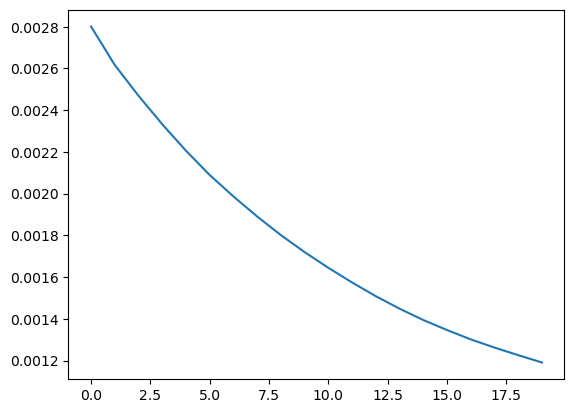

In [575]:
optimality_gap.plot()

<Axes: xlabel='Store'>

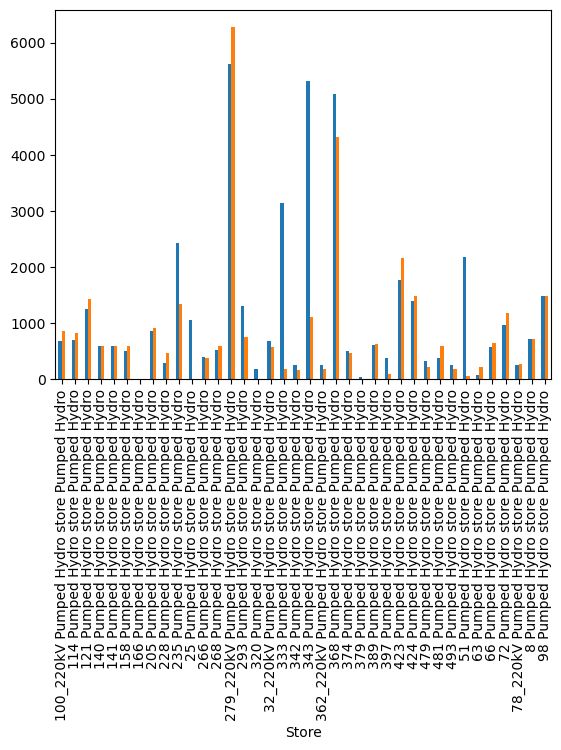

In [555]:
pd.DataFrame([e_initial.loc[n2.snapshots[0]], n_opt.stores_t.e.loc[n1.snapshots[-1]]]).T.plot.bar(legend=False)

Store
100_220kV Pumped Hydro store Pumped Hydro     867.0
114 Pumped Hydro store Pumped Hydro           828.0
121 Pumped Hydro store Pumped Hydro          1428.0
140 Pumped Hydro store Pumped Hydro           600.0
141 Pumped Hydro store Pumped Hydro           600.0
158 Pumped Hydro store Pumped Hydro           600.0
166 Pumped Hydro store Pumped Hydro             9.0
205 Pumped Hydro store Pumped Hydro           918.0
228 Pumped Hydro store Pumped Hydro           475.0
235 Pumped Hydro store Pumped Hydro          1340.0
25 Pumped Hydro store Pumped Hydro              0.0
266 Pumped Hydro store Pumped Hydro           375.0
268 Pumped Hydro store Pumped Hydro           600.0
279_220kV Pumped Hydro store Pumped Hydro    6271.0
293 Pumped Hydro store Pumped Hydro           754.0
320 Pumped Hydro store Pumped Hydro             0.0
32_220kV Pumped Hydro store Pumped Hydro      580.0
333 Pumped Hydro store Pumped Hydro           185.0
342 Pumped Hydro store Pumped Hydro           168.0
343 Pu

In [314]:
n2.stores.e_initial.round()

Store
100_220kV Pumped Hydro store Pumped Hydro     661.0
114 Pumped Hydro store Pumped Hydro           549.0
121 Pumped Hydro store Pumped Hydro           681.0
140 Pumped Hydro store Pumped Hydro           562.0
141 Pumped Hydro store Pumped Hydro           563.0
158 Pumped Hydro store Pumped Hydro           599.0
166 Pumped Hydro store Pumped Hydro             9.0
205 Pumped Hydro store Pumped Hydro           587.0
228 Pumped Hydro store Pumped Hydro           555.0
235 Pumped Hydro store Pumped Hydro           541.0
25 Pumped Hydro store Pumped Hydro              0.0
266 Pumped Hydro store Pumped Hydro           543.0
268 Pumped Hydro store Pumped Hydro           599.0
279_220kV Pumped Hydro store Pumped Hydro     770.0
293 Pumped Hydro store Pumped Hydro           721.0
320 Pumped Hydro store Pumped Hydro           453.0
32_220kV Pumped Hydro store Pumped Hydro      631.0
333 Pumped Hydro store Pumped Hydro             0.0
342 Pumped Hydro store Pumped Hydro           478.0
343 Pu

In [56]:
e_initial

Store,100_220kV Pumped Hydro store Pumped Hydro,114 Pumped Hydro store Pumped Hydro,121 Pumped Hydro store Pumped Hydro,140 Pumped Hydro store Pumped Hydro,141 Pumped Hydro store Pumped Hydro,158 Pumped Hydro store Pumped Hydro,166 Pumped Hydro store Pumped Hydro,205 Pumped Hydro store Pumped Hydro,228 Pumped Hydro store Pumped Hydro,235 Pumped Hydro store Pumped Hydro,...,479 Pumped Hydro store Pumped Hydro,481 Pumped Hydro store Pumped Hydro,493 Pumped Hydro store Pumped Hydro,51 Pumped Hydro store Pumped Hydro,63 Pumped Hydro store Pumped Hydro,66 Pumped Hydro store Pumped Hydro,72 Pumped Hydro store Pumped Hydro,78_220kV Pumped Hydro store Pumped Hydro,8 Pumped Hydro store Pumped Hydro,98 Pumped Hydro store Pumped Hydro
snapshot,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
